In [2]:
import pandas as pd
import dvc.api

In [47]:
df_800k = pd.read_json(dvc.api.get_url(
    'datasets/data/query/top_used_wish_queries.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [56]:
df_800k.gmv.mean(), df_800k.gmv.median(), df_800k.gmv.max()

(616.9796415624822, 95.118057251, 2046329.625)

In [81]:
df_800k.gmv.mean()

616.9796415624822

In [60]:
df_800k_long = df_800k[df_800k['query'].apply(lambda x: x.count(" ") >= 2)]

In [62]:
df_800k_long.gmv.mean(), df_800k_long.gmv.median(), df_800k_long.gmv.max()

(527.5161262799047, 105.42563247679999, 1043448.6875)

In [3]:
df = pd.read_json(dvc.api.get_url(
    'datasets/data/query/wish_queries_with_timestamp_3yr_3wordsormore_sample_10M_headtail.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [73]:
tmp = set(df[df.sample_method == 'head']['query']).intersection(set(df_800k_long['query']))

In [76]:
len(tmp) / len(df_800k_long), len(tmp) / len(df[df.sample_method == 'head'])

(1.0, 0.0446335)

In [63]:
df.gmv.mean(), df.gmv.median(), df.gmv.max()

(60.90367317459268, 0.0, 1626309.125)

In [77]:
df[df.sample_method == 'head'].gmv.mean(), df[df.sample_method == 'head'].gmv.median(), df[df.sample_method == 'head'].gmv.max()

(75.69147587114021, 0.0, 1626309.125)

In [4]:
df_cats = pd.read_json('../../models/multitask_multimodal_multilingual/version_9/clm-epoch=1-step=2600--wish_3yr_queries_3wordormore_10M_headtail_sample--predict.json', lines=True)

In [5]:
df_cats_group = df_cats.groupby('batch_indices').agg({ 
    "prediction_decoded": lambda x: [i for i in x], 
    "rank_indices": lambda x: [i for i in x]
})

In [6]:
df_cats_group = df_cats_group.reset_index()

In [7]:
df_cats_group = df_cats_group.sort_values('batch_indices')

In [8]:
df_cats_group.rank_indices.apply(lambda x: x[0] == 0).all()

True

In [11]:
df_cats_group['query'] = df['query']
df_cats_group['cnt'] = df['cnt']
df_cats_group['gmv'] = df['gmv']
df_cats_group['min_dt'] = df['min_dt']
df_cats_group['max_dt'] = df['max_dt']
df_cats_group['sample_method'] = df['sample_method']
df_cats_group['label_ordering'] = df['label_ordering']

In [17]:
df_tax = pd.read_json(dvc.api.get_url(
    'datasets/data/taxonomy/wish_newtax.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [18]:
small2largetax = {}
for i in df_tax[df_tax.is_leaf]['category_path'].tolist():
    small2largetax[i.lower().strip()] = i.strip()

In [86]:
df_cats_group['top_query_classification_taxonomy'] = df_cats_group['prediction_decoded'].apply(lambda x: small2largetax[x[0]])

In [88]:
df_meta = pd.read_csv(dvc.api.get_url(
    'datasets/data/attribute_extraction_metadata_template/attribute_definition_top25L2_filtered_augmented_01162023.csv',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
))

In [89]:
valid_cats = set(df_meta['category'].apply(lambda x: x.lower().strip()))

In [91]:
df_cats_group['query'].apply(lambda x: x.count(" ") >= 2).all()

True

In [92]:
df_cats_group_sub = df_cats_group[(df_cats_group['prediction_decoded'].apply(lambda x: x[0] in valid_cats))]

In [93]:
len(df_cats_group_sub)

3240015

<AxesSubplot: ylabel='top_query_classification_taxonomy'>

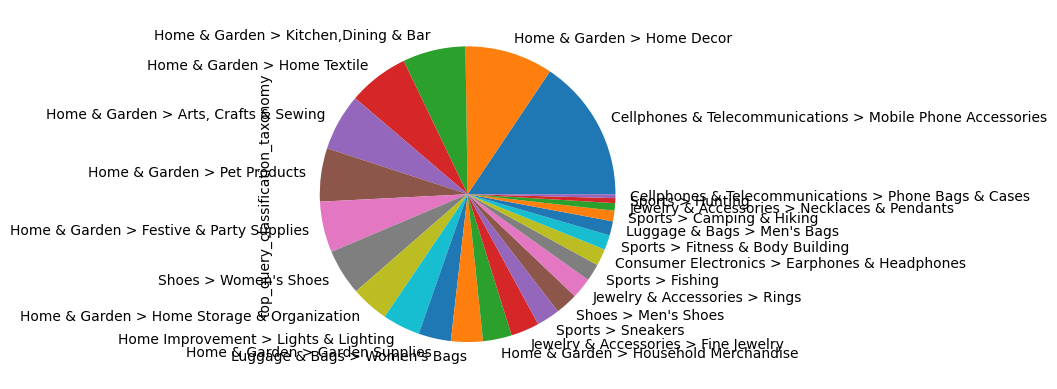

In [114]:
df_cats_group_sub_head = df_cats_group_sub[df_cats_group_sub.sample_method == 'head'].sort_values('cnt', ascending=False).head(400000)
df_cats_group_sub_head['top_query_classification_taxonomy'].apply(
    lambda x: ' > '.join(x.split(' > ')[:2])).value_counts().plot.pie()

100000


<AxesSubplot: ylabel='top_query_classification_taxonomy'>

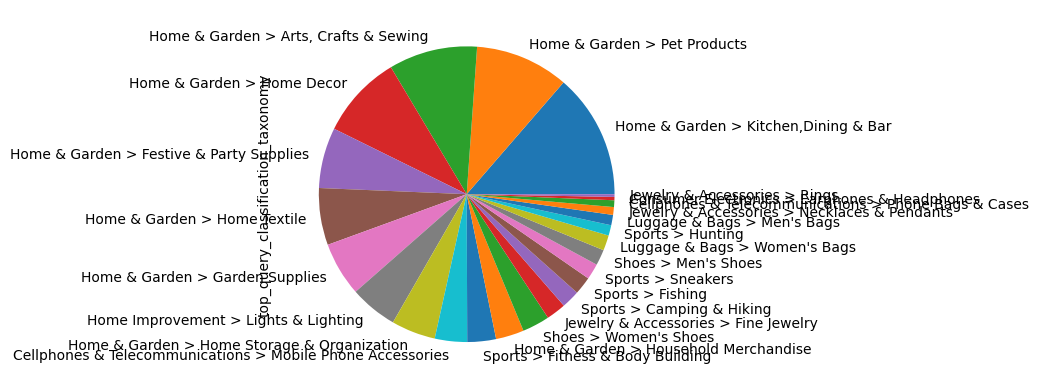

In [115]:
df_cats_group_sub_tail = df_cats_group_sub[df_cats_group_sub.sample_method == 'uniform'].groupby('top_query_classification_taxonomy').sample(
    500, replace=True, random_state=42).drop_duplicates('query').sample(100000, random_state=42)
print(len(df_cats_group_sub_tail))
df_cats_group_sub_tail['top_query_classification_taxonomy'].apply(
    lambda x: ' > '.join(x.split(' > ')[:2])).value_counts().plot.pie()

In [116]:
df_cats_group_sub_headtail = pd.concat([df_cats_group_sub_head, df_cats_group_sub_tail])

<AxesSubplot: ylabel='top_query_classification_taxonomy'>

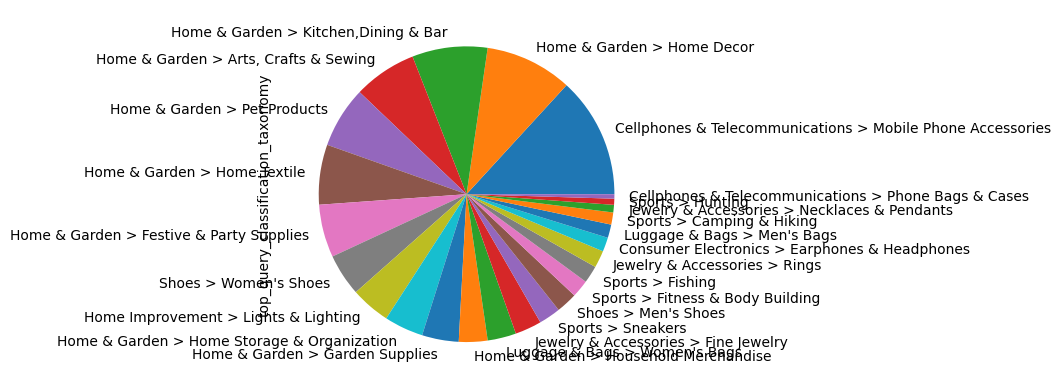

In [117]:
df_cats_group_sub_headtail['top_query_classification_taxonomy'].apply(
    lambda x: ' > '.join(x.split(' > ')[:2])).value_counts().plot.pie()

<AxesSubplot: ylabel='sample_method'>

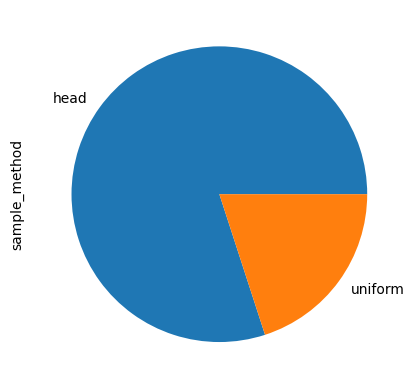

In [119]:
df_cats_group_sub_headtail['sample_method'].value_counts().plot.pie()

In [121]:
import numpy as np

<AxesSubplot: ylabel='Frequency'>

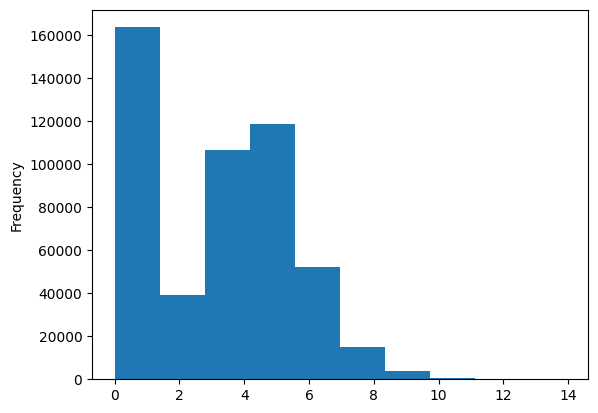

In [123]:
df_cats_group_sub_headtail.gmv.apply(lambda x: np.log(x + 1)).plot.hist()

In [125]:
df_cats_group_sub_headtail[df_cats_group_sub_headtail.sample_method == 'head'].gmv.mean()

385.8927916236451

<AxesSubplot: ylabel='min_dt'>

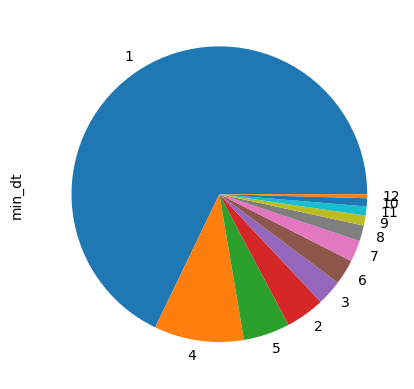

In [129]:
df_cats_group_sub_headtail['min_dt'].astype("datetime64").dt.month.value_counts().plot.pie()

In [138]:
df_out = df_cats_group_sub_headtail[['query', 'sample_method', 'label_ordering', 'top_query_classification_taxonomy']].sort_values('label_ordering')

In [144]:
b1, b2, b3, b4 = np.array_split(df_out, 4)

In [147]:
b1.to_csv('appen_query_attribution_batch1.csv', index=False)
b2.to_csv('appen_query_attribution_batch2.csv', index=False)
b3.to_csv('appen_query_attribution_batch3.csv', index=False)
b4.to_csv('appen_query_attribution_batch4.csv', index=False)

In [148]:
assert len(df_out) == len(set(df_out['query']))